## Importing libraries

In [ ]:
#Scrapping libraries
import scrapy
import logging
from scrapy.crawler import CrawlerProcess
from scrapy_selenium import SeleniumRequest

In [1]:
#Essentials
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#Preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
#Modeling and evaluation
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from statsmodels.compat import lzip
import statsmodels.api as sm
import statsmodels.stats.api as sms

In [ ]:
#Spider to scrap de data, it can also be run as .py file
class HousesSpider(scrapy.Spider):
    name = 'vivanuncios'
    custom_settings = {'FEEDS': { 'data_houses.csv': { 'format': 'csv'}}
        }
    def remove_characters(self, value):
        return value.strip(' m²')

    def remove_coma(self, value):
        return value.strip(',')

    def remove_plus(self, value):
        return value.strip('+')

    def start_requests(self):
        urls = [f'https://www.vivanuncios.com.mx/s-venta-inmuebles/mazatlan/page-{i}/v1c1097l11875p{i}'.format(i) for i
                in range(1, 51)]
        for url in urls:
            yield SeleniumRequest(
                url=url,
                wait_time=5,
                callback=self.parse
            )

    
    def parse(self, response):
        homes = response.xpath("//div[@id='tileRedesign']/div")
        for home in homes:
            yield {
                'price': home.xpath("normalize-space(.//span[@class='ad-price']/text())").get(),
                'location': home.xpath(".//div[@class='tile-location one-liner']/b/text()").get(),
                'description': home.xpath(".//div[@class='tile-desc one-liner']/a/text()").get(),
                'bathrooms': self.remove_plus(
                    home.xpath("normalize-space(//div[@class='chiplets-inline-block re-bathroom']/text())").get()),
                'bedrooms': self.remove_plus(
                    home.xpath("normalize-space(.//div[@class='chiplets-inline-block re-bedroom']/text())").get()),
                'm2': self.remove_characters(
                    home.xpath("normalize-space(.//div[@class='chiplets-inline-block surface-area']/text())").get()),
            }

In [ ]:
#Running the spider inside the notebook
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'})

process.crawl(HousesSpider)
process.start()

# Loading data

In [51]:
df = pd.read_csv('data_houses.csv')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397 entries, 0 to 1396
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   price        1343 non-null   object
 1   location     1347 non-null   object
 2   description  1347 non-null   object
 3   bathrooms    1397 non-null   int64 
 4   bedrooms     1347 non-null   object
 5   m2           811 non-null    object
dtypes: int64(1), object(5)
memory usage: 65.6+ KB


In [53]:
df.shape

(1397, 6)

In [54]:
df.isna().sum()

price           54
location        50
description     50
bathrooms        0
bedrooms        50
m2             586
dtype: int64

# Preprocessing

### Extracting information from description field

In [55]:
keywords = ['apartment', 'house', 'NOTA']

In [56]:
df.description = df['description'].astype(str).str.lower()
df['description'] = df['description'].str.replace('departamento', 'apartment')
df['description'] = df['description'].str.replace('departamentos', 'apartment')
df['description'] = df['description'].str.replace('casa', 'house')
df['description'] = df['description'].str.replace('casas', 'house')
df['description'] = df['description'].str.replace('condominio', 'NOTA')
df['description'] = df['description'].str.replace('condominios', 'NOTA')
df['description'] = df['description'].str.replace('penthouse', 'NOTA')
df['description'] = df['description'].str.replace('residencial', 'NOTA')

In [57]:
df2=df.copy()

In [58]:
df2['prop'] = df2['description'].apply(lambda x:   x.split(' ') )
df2 = df2.explode('prop')
df2 = df2[df2['prop'].isin(keywords)]
df2 = pd.get_dummies(df2, columns=['prop']).drop_duplicates()

### Matching the currency used for price to be MXN

In [59]:
#Value in MXN of one USD
curr_rate = 18.39
multiplier = np.where(df2['price'].str.contains('USD'), curr_rate, 1)

In [60]:
def clean_currency(x):
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', '').replace('USD',''))
    return(x)

In [61]:
df2['price'] = df2['price'].apply(clean_currency).astype('float')
df2.price = df2['price'] * multiplier

In [62]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 938 entries, 4 to 1393
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           935 non-null    float64
 1   location        938 non-null    object 
 2   description     938 non-null    object 
 3   bathrooms       938 non-null    int64  
 4   bedrooms        938 non-null    object 
 5   m2              538 non-null    object 
 6   prop_NOTA       938 non-null    uint8  
 7   prop_apartment  938 non-null    uint8  
 8   prop_house      938 non-null    uint8  
dtypes: float64(1), int64(1), object(4), uint8(3)
memory usage: 54.0+ KB


### Working with format values, NaN and sample size

In [63]:
df2.fillna(0, inplace = True)

In [64]:
df2.reset_index(inplace = True, drop = True)

In [65]:
df2.m2 = df2.m2.astype(str)
df2.bedrooms = df2.bedrooms.astype(str)

In [66]:
m2 = df2.m2.apply(lambda x: (x.split('-')))
bedrooms = df2.bedrooms.apply(lambda x: (x.split('-')))

In [67]:
for i in range(0, len(df2)):
    m2[i] = np.min(pd.to_numeric(m2[i]))
    bedrooms[i] = np.min(pd.to_numeric(bedrooms[i]))

In [68]:
df2.m2 = m2.astype(float)
df2.bedrooms = bedrooms.astype(float)

In [69]:
df2['m2'].replace(0, np.nan, inplace = True)
df2['price'].replace(0, np.nan, inplace = True)

In [70]:
df3 = df2.drop('description', axis = 1).copy()

In [71]:
df3 = df3.loc[((df3['m2'] < 500) & (df3['m2']>20)) | (df3['m2'].isna())]

In [72]:
lenc = LabelEncoder()
df3['location'] = lenc.fit_transform(df3.location)

In [73]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
df3= pd.DataFrame(imputer.fit_transform(df3), columns = df3.columns)

In [74]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
price,898.0,5.274341e+06,3.845649e+06,370000.0,2832322.25,4100000.0,6.737366e+06,27995000.0
location,898.0,4.404343e+01,2.706274e+01,0.0,13.00,49.0,7.300000e+01,86.0
bathrooms,898.0,2.219376e+00,8.730978e-01,1.0,2.00,2.0,3.000000e+00,4.0
bedrooms,898.0,2.761693e+00,8.738759e-01,0.0,2.00,3.0,3.000000e+00,6.0
m2,898.0,1.901114e+02,8.803903e+01,44.0,125.00,180.0,2.213333e+02,498.0
prop_NOTA,898.0,1.525612e-01,3.597644e-01,0.0,0.00,0.0,0.000000e+00,1.0
prop_apartment,898.0,3.596882e-01,4.801764e-01,0.0,0.00,0.0,1.000000e+00,1.0
prop_house,898.0,4.877506e-01,5.001285e-01,0.0,0.00,0.0,1.000000e+00,1.0


In [75]:
mms = MinMaxScaler()
df3[df3.columns] = mms.fit_transform(df3[df3.columns].copy())

In [76]:
df3.sum()

price             159.424370
location          459.895349
bathrooms         365.000000
bedrooms          413.333333
m2                289.004405
prop_NOTA         137.000000
prop_apartment    323.000000
prop_house        438.000000
dtype: float64

In [77]:
df3.head()

,price,location,bathrooms,bedrooms,m2,prop_NOTA,prop_apartment,prop_house
0,0.312398,0.569767,0.333333,0.333333,0.667401,1.0,0.0,0.0
1,0.283439,0.546512,0.333333,0.500000,0.432452,0.0,1.0,0.0
2,0.022805,0.325581,0.333333,0.333333,0.026432,0.0,0.0,1.0
3,0.095855,0.441860,0.333333,0.333333,0.052863,0.0,1.0,0.0
4,0.116923,0.744186,0.333333,0.500000,0.145374,0.0,0.0,1.0


In [78]:
df3.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
price,898.0,0.177533,0.139209,0.0,0.089134,0.135023,0.230493,1.0
location,898.0,0.512133,0.314683,0.0,0.151163,0.569767,0.848837,1.0
bathrooms,898.0,0.406459,0.291033,0.0,0.333333,0.333333,0.666667,1.0
bedrooms,898.0,0.460282,0.145646,0.0,0.333333,0.500000,0.500000,1.0
m2,898.0,0.321831,0.193919,0.0,0.178414,0.299559,0.390602,1.0
prop_NOTA,898.0,0.152561,0.359764,0.0,0.000000,0.000000,0.000000,1.0
prop_apartment,898.0,0.359688,0.480176,0.0,0.000000,0.000000,1.000000,1.0
prop_house,898.0,0.487751,0.500128,0.0,0.000000,0.000000,1.000000,1.0


### General distribution of the price by area and location

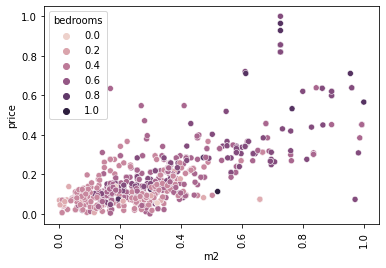

In [79]:
plt.style.use('tableau-colorblind10')
sns.scatterplot(x = df3.m2, y = df3.price, hue = df3.bedrooms)
plt.xticks(rotation = 90)
plt.show();

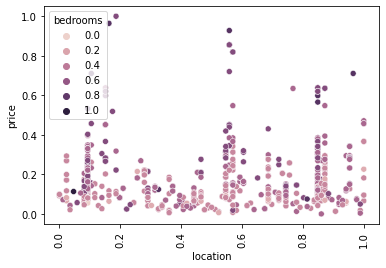

In [80]:
sns.scatterplot(x = df3.location, y = df3.price, hue = df3.bedrooms)
plt.xticks(rotation = 90)
plt.show();

# Statiscal Analysis

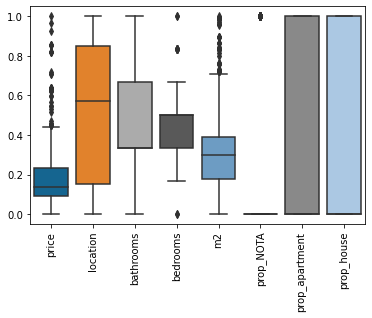

In [81]:
sns.boxplot(data=df3)
plt.xticks(rotation = 90)
plt.show();

### Correlation visualization of the attributes

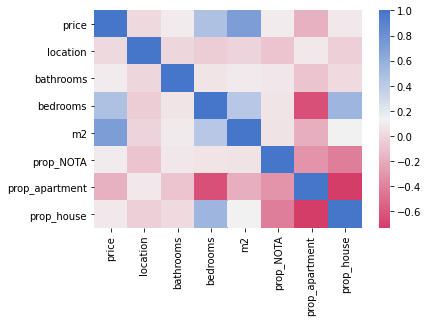

In [82]:
cmap = sns.diverging_palette(0, 255, as_cmap=True)
sns.heatmap(df3.corr(), cmap=cmap)
plt.show();

In [83]:
df3

,price,location,bathrooms,bedrooms,m2,prop_NOTA,prop_apartment,prop_house
0,0.312398,0.569767,0.333333,0.333333,0.667401,1.0,0.0,0.0
1,0.283439,0.546512,0.333333,0.500000,0.432452,0.0,1.0,0.0
2,0.022805,0.325581,0.333333,0.333333,0.026432,0.0,0.0,1.0
3,0.095855,0.441860,0.333333,0.333333,0.052863,0.0,1.0,0.0
4,0.116923,0.744186,0.333333,0.500000,0.145374,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
893,0.080724,0.093023,0.333333,0.333333,0.057269,0.0,1.0,0.0
894,0.221719,0.093023,0.333333,0.500000,0.255507,0.0,0.0,1.0
895,0.221719,0.093023,0.333333,0.500000,0.255507,1.0,0.0,0.0
896,0.120543,0.848837,0.333333,0.500000,0.185022,0.0,0.0,1.0


In [84]:
#WCSS is calculated for different number of clusters and plotted to apply the Elbow method.
wcss = [] 
for i in range(1, 10): 
    kmeans_wcss = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_wcss.fit(df3) 
    wcss.append(kmeans_wcss.inertia_)

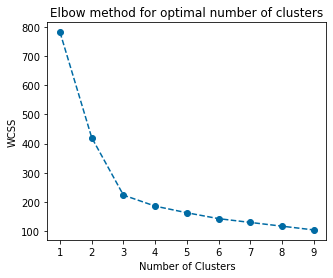

In [85]:
plt.figure(figsize=(5,4))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow method for optimal number of clusters')
plt.show()

In [86]:
#Silhouette Score is calculated for different number of clusters.
silhouette_coefficients = []
for i in range(2,10): 
    model_km_ss = KMeans(n_clusters=i, random_state=42)
    # Fit the KMeans model
    model_km_ss.fit_predict(df3)
    # Calculate Silhoutte Score
    score = silhouette_score(df3, model_km_ss.labels_, metric='euclidean')
    # Print the score
    print('Number of clusters ',i, 'Silhouetter Score: %.3f' % score)
    silhouette_coefficients.append(score)

Number of clusters  2 Silhouetter Score: 0.464
Number of clusters  3 Silhouetter Score: 0.589
Number of clusters  4 Silhouetter Score: 0.467
Number of clusters  5 Silhouetter Score: 0.368
Number of clusters  6 Silhouetter Score: 0.380
Number of clusters  7 Silhouetter Score: 0.388
Number of clusters  8 Silhouetter Score: 0.356
Number of clusters  9 Silhouetter Score: 0.364


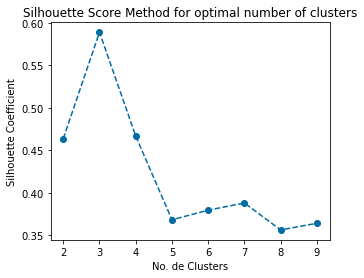

In [87]:
#Silhouette Scores are plotted against the number of clusters.
plt.figure(figsize=(5,4))
plt.plot(range(2,10),silhouette_coefficients,marker='o',linestyle='--')
plt.xticks(range(2, 10))
plt.xlabel("No. de Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Silhouette Score Method for optimal number of clusters')
plt.show()

In [88]:
# KMeans
model_KM = KMeans(n_clusters=3)
model_KM.fit(df3)
yhat_KM=model_KM.predict(df3)

In [89]:
print(model_KM.cluster_centers_)

[[ 2.11569132e-01  4.50178238e-01  4.64720195e-01  4.85401460e-01
   3.49298477e-01  1.00000000e+00  6.10622664e-16 -6.10622664e-16]
 [ 1.45554277e-01  5.50795594e-01  3.72549020e-01  3.36945304e-01
   2.73814232e-01  4.99600361e-16  1.00000000e+00  1.16573418e-15]
 [ 1.90468874e-01  5.02999894e-01  4.13242009e-01  5.43378995e-01
   3.48649582e-01  3.33066907e-16 -6.66133815e-16  1.00000000e+00]]


In [90]:
#The assigned cluster values are added to a new column in the main dataframe.
#UPDF
data_clu = pd.DataFrame(mms.inverse_transform(df3), columns = df3.columns)
data_clu['Cluster']=yhat_KM.copy()
data_clu.sample(8)

,price,location,bathrooms,bedrooms,m2,prop_NOTA,prop_apartment,prop_house,Cluster
777,7500000.0,65.0,2.0,2.0,223.666667,0.0,1.0,0.0,1
626,4230000.0,73.0,2.0,3.0,119.000000,0.0,0.0,1.0,2
336,5500000.0,73.0,2.0,3.0,144.000000,0.0,0.0,1.0,2
314,2975000.0,38.0,4.0,2.0,227.000000,0.0,1.0,0.0,1
210,2720776.0,47.0,2.0,1.0,176.333333,0.0,1.0,0.0,1
86,3950000.0,73.0,2.0,3.0,186.333333,0.0,0.0,1.0,2
705,4650000.0,73.0,2.0,3.0,120.000000,0.0,0.0,1.0,2
732,480000.0,85.0,2.0,3.0,120.000000,0.0,0.0,1.0,2


In [91]:
#Average values of the main dataframe according to the assigned cluster
cc=(pd.concat([data_clu.groupby(by='Cluster').size(),round(data_clu.groupby(by='Cluster').mean(), 0)],axis=1))
cc.columns.values[0:1]='Frecuencia'
cc.T

Cluster,0,1,2
Frecuencia,137.0,323.0,438.0
price,6214597.0,4390937.0,5631703.0
location,39.0,47.0,43.0
bathrooms,2.0,2.0,2.0
bedrooms,3.0,2.0,3.0
m2,203.0,168.0,202.0
prop_NOTA,1.0,0.0,0.0
prop_apartment,0.0,1.0,0.0
prop_house,0.0,0.0,1.0


In [92]:
data_clu.head()

,price,location,bathrooms,bedrooms,m2,prop_NOTA,prop_apartment,prop_house,Cluster
0,9000000.0,49.0,2.0,2.0,347.000000,1.0,0.0,0.0,0
1,8200000.0,47.0,2.0,3.0,240.333333,0.0,1.0,0.0,1
2,1000000.0,28.0,2.0,2.0,56.000000,0.0,0.0,1.0,2
3,3018000.0,38.0,2.0,2.0,68.000000,0.0,1.0,0.0,1
4,3600000.0,64.0,2.0,3.0,110.000000,0.0,0.0,1.0,2


In [93]:
df_clu = df3.copy()
df_clu['Cluster'] =yhat_KM.copy()
df_clu.head(4)

,price,location,bathrooms,bedrooms,m2,prop_NOTA,prop_apartment,prop_house,Cluster
0,0.312398,0.569767,0.333333,0.333333,0.667401,1.0,0.0,0.0,0
1,0.283439,0.546512,0.333333,0.500000,0.432452,0.0,1.0,0.0,1
2,0.022805,0.325581,0.333333,0.333333,0.026432,0.0,0.0,1.0,2
3,0.095855,0.441860,0.333333,0.333333,0.052863,0.0,1.0,0.0,1


In [94]:
#Grouping the data by cluster
df_clu=df_clu.groupby('Cluster')

In [95]:
#Function for selecting the cluster to analyze and continue working with
def cluster_selector(value):
    Xr = None
    yr = None
    
    if value == 0:
        Xr=df_clu.get_group(0).drop(axis=1, columns=['price']).reset_index(drop=True)
        yr=df_clu.get_group(0)[['price']].reset_index(drop=True)

    elif value == 1:
        Xr=df_clu.get_group(1).drop(axis=1, columns=['price']).reset_index(drop=True)
        yr=df_clu.get_group(1)[['price']].reset_index(drop=True)
        

    elif value == 2:
        Xr=df_clu.get_group(2).drop(axis=1, columns=['price']).reset_index(drop=True)
        yr=df_clu.get_group(2)[['price']].reset_index(drop=True)

    else:
        print("Invalid value. Please provide a value between 0 and 2.")
        return
    
    return Xr, yr

### Select a cluster (from 0 to 2) by changing the number between parantheses

In [96]:
cs = cluster_selector(1)

Xr = cs[0]
yr = cs[1]

## Linear Regression

In [97]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.25, random_state=1)

In [98]:
Xr_train = sm.add_constant(Xr_train, prepend=True)
Xr_test = sm.add_constant(Xr_test, prepend=True)
modelo_ols = sm.OLS(endog=yr_train, exog=Xr_train)
modelo_ols = modelo_ols.fit()
(modelo_ols.summary())

C:\Users\Win10\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     56.33
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           2.39e-33
Time:                        19:12:24   Log-Likelihood:                 298.92
No. Observations:                 242   AIC:                            -587.8
Df Residuals:                     237   BIC:                            -570.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
location           0.0244      0.016      1.564      0.119      -0.006       0.055
bathrooms         -0.0161      0.017     -0.974      0.331      -0.049       0.016
bedrooms           0.5048      0.056      8.976      0.000       0.394       0.616
m2                 0.2642      0.033      8.048      0.000       0.200       0.329
prop_NOTA       1.061e-16    1.3e-17      8.142      0.000    8.04e-17    1.32e-16
prop_apartment    -0.0541      0.010     -5.293      0.000      -0.074      -0.034
prop_house              0          0        nan        nan           0           0
Cluster           -0.0541      0.010     -5.293      0.000      -0.074      -0.034
==============================================================================
Omnibus:                      119.393   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              870.337
Skew:                           1.806   Prob(JB):                    1.02e-189
Kurtosis:                      11.560   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [101]:
# Bresuch-Pagan test
names = ['Lagrange multiplier statistics', 'P value',
        'F value', 'p f value']
test = sms.het_breuschpagan (modelo_ols.resid, modelo_ols.model.exog)

lzip (names, test)

[('Lagrange multiplier statistics', 39.81688112701768),
 ('P value', 1.364550318142702e-06),
 ('F value', 11.66838369061805),
 ('p f value', 1.1490565665268243e-08)]

In [102]:
# Confidence intervals for the coefficients of the model
ci_intervals = modelo_ols.conf_int(alpha=0.05)
ci_intervals.columns = ['2.5%', '97.5%']
ci_intervals

,2.5%,97.5%
location,-6.321098e-03,5.508194e-02
bathrooms,-4.873076e-02,1.648722e-02
bedrooms,3.939920e-01,6.155536e-01
m2,1.995376e-01,3.288970e-01
prop_NOTA,8.039758e-17,1.317232e-16
prop_apartment,-7.425960e-02,-3.397292e-02
prop_house,0.000000e+00,0.000000e+00
Cluster,-7.425960e-02,-3.397292e-02


In [103]:
# Diagnostic errors (residuals) of training predictions
yr_rl_pred_train = modelo_ols.predict(exog = Xr_train)
yr_rl_pred_test = modelo_ols.predict(exog = Xr_test)
residuos_train = yr_rl_pred_train.to_numpy().flatten() - yr_train.to_numpy().flatten() 

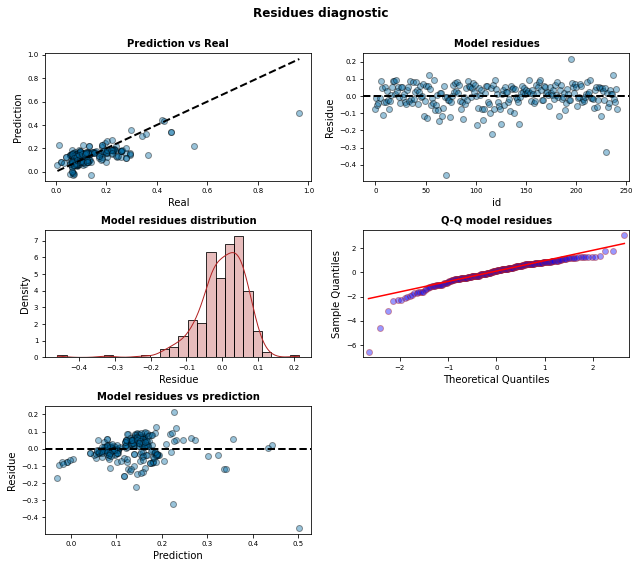

In [104]:
# Graphics
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(yr_train, yr_rl_pred_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([yr_train.min(), yr_train.max()], [yr_train.min(), yr_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Prediction vs Real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Prediction')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(yr_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Model residues', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residue')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Model residues distribution', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residue")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q model residues', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(yr_rl_pred_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Model residues vs prediction', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Prediction')
axes[2, 0].set_ylabel('Residue')
axes[2, 0].tick_params(labelsize = 7)


fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Residues diagnostic', fontsize = 12, fontweight = "bold");

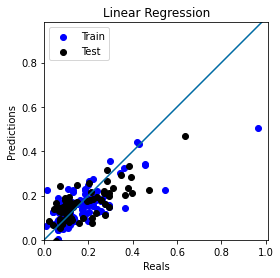

In [105]:
#Predictions are plotted using the training and test input data.
plt.scatter(yr_train, yr_rl_pred_train,color="b", label='Train')
plt.scatter(yr_test, yr_rl_pred_test,color="k", label='Test')
plt.xlabel('Reals')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.legend(loc="upper left")
plt.title("Linear Regression")
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [106]:
# Finally, we calculate the mean square error and the R^2 statistic.
print ('Train MSE: ', mean_squared_error(yr_train, yr_rl_pred_train))
print ('Test MSE: ', mean_squared_error(yr_test, yr_rl_pred_test))
print ('Test R^2: ', r2_score(yr_train, yr_rl_pred_train))
print ('Test R^2: ', r2_score(yr_test, yr_rl_pred_test))

Train MSE:  0.004950370237361087
Test MSE:  0.006835137389555048
Test R^2:  0.4873889854723642
Test R^2:  0.4810559185406622


## Neural Network Regression

In [107]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
print(tf.__version__)

2.9.1


In [108]:
#The model is defined and compiled with two intermediate layers
model_rrn = Sequential([
Dense(64, activation='relu', input_shape=[Xr_train.shape[1]]),
Dense(128, activation='relu'),
Dense(64, activation='relu'),
Dense(1)
])

model_rrn.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mae','mse'])

In [109]:
#The summary of the model is shown
model_rrn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
_________________________________________________________________


In [110]:
# A function is defined that displays the training process by printing a dot after each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

#The model is trained on a variable for later use.
history = model_rrn.fit(Xr_train, yr_train, epochs=50, validation_split = 0.2, verbose=0, callbacks=[PrintDot()])


..................................................

In [111]:
#The values of the metrics for each epoch of the model training are obtained and the latest values are shown.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(5)

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
45,0.003281,0.040063,0.003281,0.005992,0.047017,0.005992,45
46,0.003435,0.040754,0.003435,0.006138,0.051558,0.006138,46
47,0.003502,0.048141,0.003502,0.006318,0.051985,0.006318,47
48,0.003272,0.040740,0.003272,0.006398,0.048945,0.006398,48
49,0.003332,0.039861,0.003332,0.006596,0.052173,0.006596,49


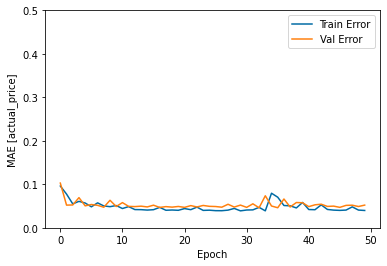

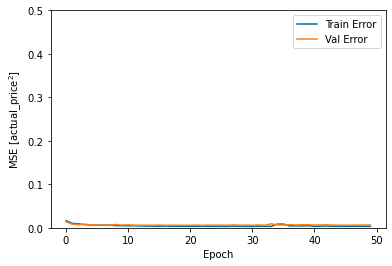

In [112]:
#A function is defined and the metrics are passed to be plotted to observe its evolution with each epoch.
def plot_history(history):

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAE [actual_price]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE [actual_price$^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.5])
  plt.legend()
  plt.show()

#The function is called on the model
plot_history(history)

In [113]:
#Metrics are extracted by equating the model with the test training sets and the metric of interest is printed.
loss, mae, mse_rrn_train = model_rrn.evaluate(Xr_train, yr_train, verbose=2)
print('Train error Neural Network (MSE): {:5.4f} price'.format(mse_rrn_train))

loss, mae, mse_rrn_test = model_rrn.evaluate(Xr_test, yr_test, verbose=2)
print("Test error Neural Network (MSE): {:5.4f} price".format(mse_rrn_test))

8/8 - 0s - loss: 0.0037 - mae: 0.0425 - mse: 0.0037 - 45ms/epoch - 6ms/step
Train error Neural Network (MSE): 0.0037 price
3/3 - 0s - loss: 0.0066 - mae: 0.0599 - mse: 0.0066 - 38ms/epoch - 13ms/step
Test error Neural Network (MSE): 0.0066 price


3/3 [==============================] - 0s 4ms/step


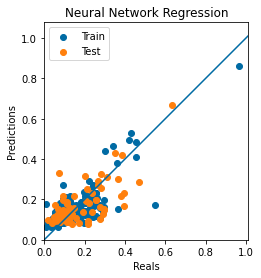

In [114]:
#Predictions are calculated and plotted using the training and test input data.
yr_rn_pred_train = model_rrn.predict(Xr_train)
yr_rn_pred_test = pd.DataFrame(model_rrn.predict(Xr_test))
plt.scatter(yr_train, yr_rn_pred_train, label='Train')
plt.scatter(yr_test, yr_rn_pred_test, label='Test')
plt.xlabel('Reals')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.legend(loc = "upper left")
plt.title("Neural Network Regression")
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [115]:
# Finally, we calculate the mean square error and the R^2 statistic.
print ('Train MSE: ', mean_squared_error(yr_train, yr_rn_pred_train))
print ('Test MSE: ', mean_squared_error(yr_test, yr_rn_pred_test))
print ('Train R^2: ', r2_score(yr_train, yr_rn_pred_train))
print ('Test R^2: ', r2_score(yr_test, yr_rn_pred_test))

Train MSE:  0.0036993142578210466
Test MSE:  0.006555469788721401
Train R^2:  0.6169358767458437
Test R^2:  0.5022891195660482


## Comparative evaluation

In [116]:
#A comparative table with the error values of the models from the test data is shown.
df_regr=pd.DataFrame({'Linear Regression MSE':[mean_squared_error(yr_test, yr_rl_pred_test)],'NN Regression MSE':[mean_squared_error(yr_test, yr_rn_pred_test)]})
df_regr

,Linear Regression MSE,NN Regression MSE
0,0.006835,0.006555


In [117]:
Xr_test.reset_index(drop = True, inplace = True)
yr_test.reset_index(drop = True, inplace = True)
yr_rl_pred_test.reset_index(drop = True, inplace = True)

In [118]:
Xr_test

,location,bathrooms,bedrooms,m2,prop_NOTA,prop_apartment,prop_house,Cluster
0,0.023256,0.333333,0.333333,0.307636,0.0,1.0,0.0,1
1,0.569767,1.000000,0.333333,0.667401,0.0,1.0,0.0,1
2,0.546512,0.333333,0.333333,0.074890,0.0,1.0,0.0,1
3,0.860465,0.333333,0.333333,0.353891,0.0,1.0,0.0,1
4,0.546512,0.333333,0.333333,0.284141,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...
76,0.546512,0.666667,0.500000,0.200441,0.0,1.0,0.0,1
77,1.000000,0.333333,0.333333,0.246696,0.0,1.0,0.0,1
78,0.093023,0.333333,0.500000,0.444200,0.0,1.0,0.0,1
79,0.279070,0.666667,0.333333,0.167401,0.0,1.0,0.0,1


In [119]:
clusters_test = Xr_test.Cluster.copy()
Xreal_test = Xr_test.drop(['Cluster'], axis = 1)

In [120]:
data_test_real = pd.concat([yr_test, Xreal_test], axis = 1)
data_test_rl = pd.concat([pd.DataFrame(yr_rl_pred_test), Xreal_test], axis = 1)
data_test_rn = pd.concat([yr_rn_pred_test, Xreal_test], axis = 1)

In [121]:
data_test_real[data_test_real.columns] = mms.inverse_transform(data_test_real[data_test_real.columns].copy())
data_test_rl[data_test_rl.columns] = mms.inverse_transform(data_test_rl[data_test_rl.columns].copy())
data_test_rn[data_test_rn.columns] = mms.inverse_transform(data_test_rn[data_test_rn.columns].copy())

In [122]:
data_test_real.rename(columns={'price': 'Real Price'}, inplace = True)
data_test_rl.rename(columns={0: 'RL Price Pred'}, inplace = True)
data_test_rn.rename(columns={0: 'RN Price Pred'}, inplace = True)

In [123]:
df_final = pd.concat([data_test_rl['RL Price Pred'], data_test_rn['RN Price Pred'], data_test_real, clusters_test], axis = 1)
df_final.head()

,RL Price Pred,RN Price Pred,Real Price,location,bathrooms,bedrooms,m2,prop_NOTA,prop_apartment,prop_house,Cluster
0,4.140836e+06,4.118630e+06,3595245.0,2.0,2.0,2.0,183.666667,0.0,1.0,0.0,1
1,6.837934e+06,8.966016e+06,9000000.0,49.0,4.0,2.0,347.000000,0.0,1.0,0.0,1
2,2.794440e+06,2.828543e+06,3790000.0,47.0,2.0,2.0,78.000000,0.0,1.0,0.0,1
3,5.042323e+06,5.261887e+06,3550000.0,74.0,2.0,2.0,204.666667,0.0,1.0,0.0,1
4,4.321765e+06,3.709982e+06,2660000.0,47.0,2.0,2.0,173.000000,0.0,1.0,0.0,1


In [124]:
cc_rp=(pd.concat([df_final.groupby(by='Cluster').size(),np.round(df_final.groupby(by='Cluster').agg(pd.Series.mean))],axis=1))
cc_rp.columns.values[0:1]='Frecuencia'
cc_rp

,Frecuencia,RL Price Pred,RN Price Pred,Real Price,location,bathrooms,bedrooms,m2,prop_NOTA,prop_apartment,prop_house
Cluster,,,,,,,,,,,
1,81,4615028.0,4999349.0,5048728.0,46.0,2.0,2.0,176.0,0.0,1.0,0.0


In [125]:
quartiles = pd.qcut(df_final["Real Price"], 4)

# Create a new dataframe with the quartiles
quartiles_df = df_final.assign(quartile=quartiles)

In [126]:
round(quartiles_df.groupby('quartile').agg(pd.Series.mean), 0)

,RL Price Pred,RN Price Pred,Real Price,location,bathrooms,bedrooms,m2,prop_NOTA,prop_apartment,prop_house,Cluster
quartile,,,,,,,,,,,
"(954996.999, 2700000.0]",3356971.0,3826760.0,2221071.0,44.0,2.0,2.0,137.0,0.0,1.0,0.0,1
"(2700000.0, 3750000.0]",3988349.0,4016829.0,3307244.0,47.0,2.0,2.0,147.0,0.0,1.0,0.0,1
"(3750000.0, 6922160.0]",4362744.0,4631230.0,5325847.0,43.0,2.0,2.0,186.0,0.0,1.0,0.0,1
"(6922160.0, 17930250.0]",6852392.0,7642645.0,9683992.0,49.0,2.0,3.0,239.0,0.0,1.0,0.0,1


In [127]:
lenc.inverse_transform([44, 47, 43, 49])

array(['Los Sauces', 'Marina Mazatlán', 'Los Portales', 'Mazatlán'],
      dtype=object)

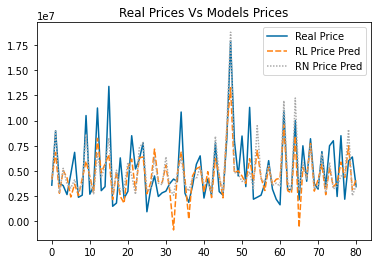

In [128]:
sns.lineplot(data = df_final[['Real Price', 'RL Price Pred', 'RN Price Pred']])
plt.title('Real Prices Vs Models Prices')
plt.show()